In [3]:
import numpy as np
import matplotlib.pyplot as plt

import math
import scipy.sparse as sps

from scipy.sparse.linalg import cg
from scipy.integrate import odeint

from fastprogress import progress_bar

import jlinops
import sampi


In [4]:
ground_truth = 100*jlinops.cameraman()
img_shape = ground_truth.shape
L = 10
n = math.prod(ground_truth.shape)
#A = jlinops.IdentityOperator( (n,n) )
A = jlinops.Gaussian2DBlurOperator(img_shape, blur_sigma=2.0)

np.random.seed(0)
noisy_signal = A.matvec(ground_truth.flatten())*np.random.gamma(shape=L, scale=1/L, size=n)

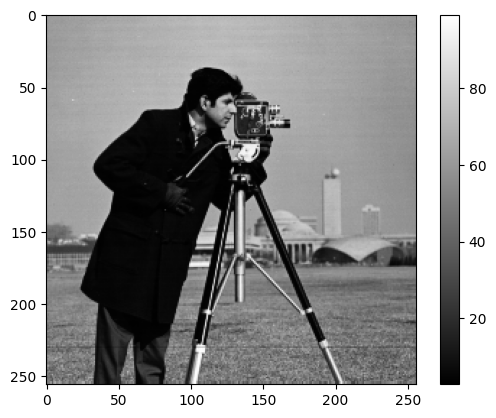

In [5]:
plt.imshow(ground_truth, cmap="gray")
plt.colorbar()
plt.show()

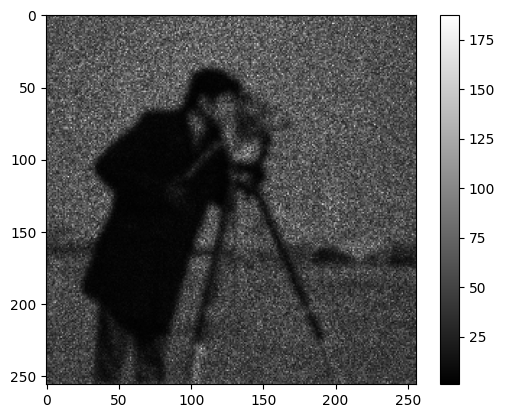

In [6]:
plt.imshow(noisy_signal.reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()

# Solver

In [7]:
class AADespecklingSolver2D:

    def __init__(self, A, f, hyperparams, L=1, grid_shape=None):

        # Bind
        assert grid_shape is not None, "must give a grid shape."
        self.grid_shape = grid_shape
        self.f = f
        self.A = A
        self.hyperparams = hyperparams
        self.L = L
        self.n = A.shape[1]

        # Build R
        self.R = jlinops.Neumann2D(grid_shape)

        # Misc
        self.m = self.n
        self.k = self.R.shape[0] # output size of regularization operator
    

    def solve(self, u0=None, maxiter=100, backtrack_alpha=0.5, backtrack_beta=0.5, search_maxiter=100):


        # Handle initialization
        if u0 is None:
            u = self.f
        else:
            u = u0


        converged = False
        obj_val = self.objective(u)
        obj_vals = [obj_val]
        lower_bound = self.hyperparams["lower_bound"]


        for j in progress_bar(range(maxiter)):

            # Compute gradient
            grad = self.grad(u)

            # Line search for projected gradient descent
            gfunc = lambda t: self.objective( self.projection( u - t*grad, lower_bound=lower_bound)  )
            step_size = 1.0
            grad_mapped = self.grad_mapping(u, M=1.0/step_size, lower_bound=lower_bound)
            searching = ( obj_val - gfunc(step_size)  ) < backtrack_alpha*step_size*(np.linalg.norm(grad_mapped)**2)
            for i in range(search_maxiter):
                if not searching:
                    break
                else:
                    step_size *= backtrack_beta
                    grad_mapped = self.grad_mapping(u, M=1.0/step_size, lower_bound=lower_bound)
                    searching = ( obj_val - gfunc(step_size)  ) < backtrack_alpha*step_size*(np.linalg.norm(grad_mapped)**2)
            assert not searching, "line search never terminated!"

            # Take step
            u = self.projection( u - step_size*grad, lower_bound=lower_bound)

            # Track objective
            obj_val = self.objective(u)
            obj_vals.append(obj_val)
            
        data = {
            "u": u,
            "obj_vals": obj_vals,
        }

        return data


    def grad(self, u):
        """Evaluates gradient of objective.
        """
        tmp = self.R @ u
        denom = np.sqrt( (np.linalg.norm(tmp)**2) + (self.hyperparams["beta"]**2) )
        first_term = -self.R.T @ (tmp/denom)
        Au = self.A.matvec(u)
        second_term = self.hyperparams["reg_lam"]*self.L*self.A.rmatvec( (Au - self.f)/(Au**2)   )
        grad = first_term + second_term

        return grad


    def objective(self, u):
        """Evaluates the objective function.
        """

        if np.any(u < self.hyperparams["lower_bound"]):
            return np.inf
        else:
            pass

        Au = self.A.matvec(u)
        obj =  self.L*( (np.log(Au) + self.f/Au  ).sum() + self.hyperparams["reg_lam"]*np.sqrt(  np.linalg.norm(self.R.matvec(u))**2 + self.hyperparams["beta"]**2    )    )
        
        return obj


    def grad_mapping(self, u, M=1, lower_bound=1e-4):
        """Evaluates gradient mapping for projected gradient descent.
        """
        return M*( u - self.projection( u - (1.0/M)*self.grad(u), lower_bound=lower_bound ) )


    def projection(self, u, lower_bound=1e-4):
        """Projects to have all entries greater than lower bound.
        """
        return np.clip(u, a_min=lower_bound, a_max=None)


# Step

In [22]:
hyperparams = {
    "reg_lam": 1e1,
    "beta": 1e-3,
    "lower_bound": 1e-3,
}

solver = AADespecklingSolver2D(A, noisy_signal, hyperparams=hyperparams, L=L, grid_shape=img_shape) 

In [25]:
data = solver.solve(
    u0=2*noisy_signal,
    maxiter=100,
    backtrack_alpha=0.1,
    backtrack_beta=0.9,
    search_maxiter=1000,
)

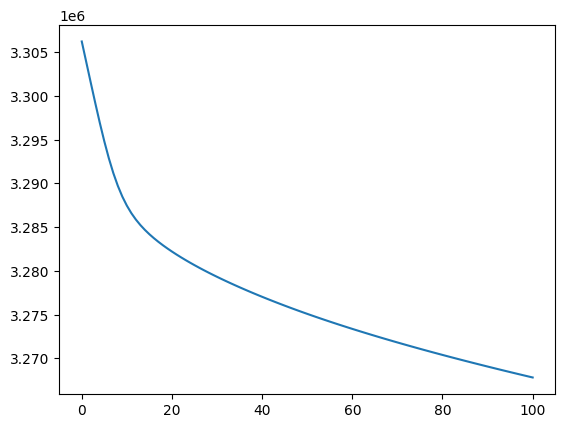

In [19]:
plt.plot(data["obj_vals"])
plt.show()

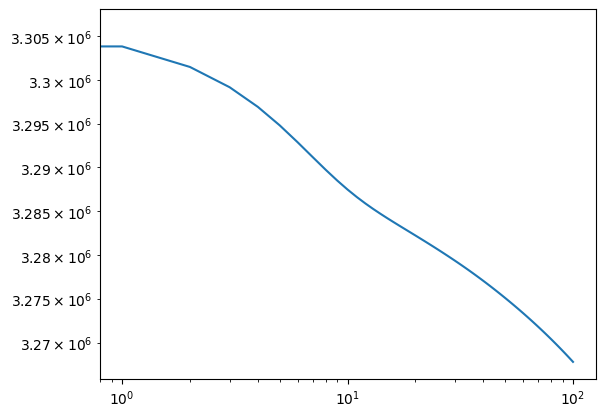

In [20]:
plt.loglog(data["obj_vals"])
plt.show()

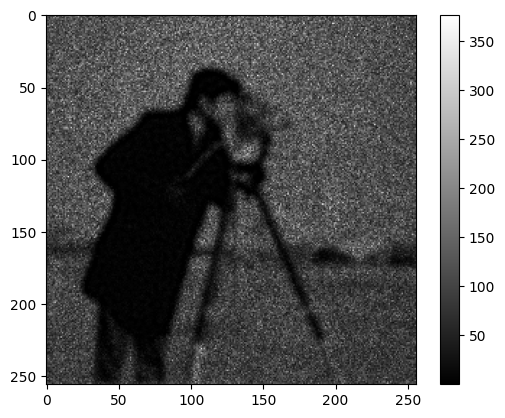

In [21]:
plt.imshow(data["u"].reshape(img_shape), cmap="gray")
plt.colorbar()
plt.show()